<a href="https://colab.research.google.com/github/eileenrmartin/IntroToDASData/blob/master/BradyHotSprings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Example with Brady Hot Springs Vibroseis



The Python packages we'll use are:

*   pandas, already available in Colab
*   matplotlib.pyplot, already available in Colab
*   obspy, needs to be installed
* maybe some others**** like scipy.fftpack or numpy?*

To run a bash (command-line) command in a Jupyter notebook on Colab, use an ! before the command. Below is the command to install obspy. 



In [1]:
!pip install obspy

     |████████████████████████████████| 24.7MB 159kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for obspy: filename=obspy-1.2.2-cp36-cp36m-linux_x86_64.whl size=21665222 sha256=96be45dc30ae931e7921ddc3efefa9fd6cf60417f666caa556cbfe9cb4c8a92d
  Stored in directory: /root/.cache/pip/wheels/94/e0/86/44fd4cea7661f42431c8f6d030f2758ff275cccffcbe8fa2b8
Successfully built obspy


All packages need to be imported before they can be used. Now that we've installed Obspy, let's load all relevant packages.

In [29]:
import pandas as pd
import numpy as np
import scipy.fftpack as ft
import matplotlib.pyplot as plt
import obspy
import csv
import struct
import ipywidgets as widgets

...some other stuff goes here...

# Reading Array Geometry

Grab csv (comma separated value) data from Geothermal Data Repository. File is at url: https://gdr.openei.org/files/829/Surface_DAS_DTS_UTM_coordinates.csv and more info is at https://openei.org/doe-opendata/dataset/brady-s-geothermal-field-das-and-dts-surface-and-borehole-array-metadata/resource/f0000003-58cc-4372-a567-000000000829

In [3]:
!wget https://gdr.openei.org/files/829/Surface_DAS_DTS_UTM_coordinates.csv

--2020-07-30 16:22:50--  https://gdr.openei.org/files/829/Surface_DAS_DTS_UTM_coordinates.csv
Resolving gdr.openei.org (gdr.openei.org)... 54.189.151.23, 54.186.144.32, 52.27.59.5
Connecting to gdr.openei.org (gdr.openei.org)|54.189.151.23|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 307372 (300K) [application/octet-stream]
Saving to: ‘Surface_DAS_DTS_UTM_coordinates.csv’

Surface_DAS_DTS_UTM 100%[===================>] 300.17K  1.18MB/s    in 0.2s    

2020-07-30 16:22:51 (1.18 MB/s) - ‘Surface_DAS_DTS_UTM_coordinates.csv’ saved [307372/307372]



Read the geometry data:

In [4]:
geomData = 'Surface_DAS_DTS_UTM_coordinates.csv'
# for this experiment,  some of the geometry is in this csv file, and some is described on the website
# location of a vibroseis source
srcX = 328552.49 
srcY = 4408006.65 
# if you  look in CSV file, these are the first and last rows with channels that have a location assigned
minRow = 53 
maxRow = 8673  
# read the geometry of all channels in the CSV file
with open(geomData) as myFile:
        myReader = csv.reader(myFile, delimiter=',')
        nRows = maxRow - minRow + 1
        ch = np.zeros(nRows,dtype=np.int) # array to hold channel indices
        x = np.zeros(nRows,dtype=np.float32) # array to hold x location
        y = np.zeros(nRows,dtype=np.float32) # array to hold y location
        myFile.seek(0)
        rowCtr = 1
        for row in myReader:
                if((rowCtr >= minRow) and (rowCtr <= maxRow)):
                        ch[rowCtr-minRow] = int(row[0])
                        x[rowCtr-minRow] = float(row[1])
                        y[rowCtr-minRow] = float(row[2])
                rowCtr = rowCtr + 1

Plot the geometry data checking distances along one subset: 



distances (m)


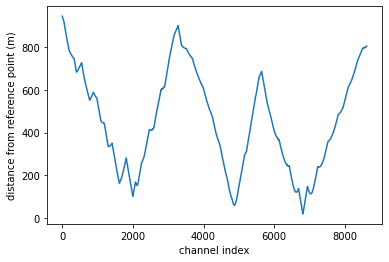

In [5]:
distances = np.sqrt((x-srcX)**2 + (y-srcY)**2)
print('distances (m)')
import matplotlib.pyplot as plt
plt.plot(distances)
plt.xlabel("channel index")
plt.ylabel("distance from reference point (m)")
plt.show()

8650
30


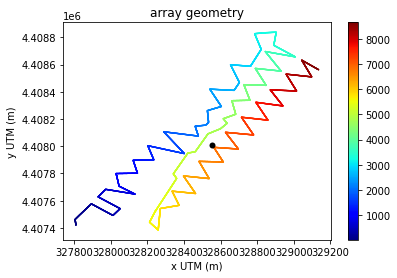

In [6]:
maxCh = np.max(ch)
minCh = np.min(ch)
print(maxCh)
print(minCh)
# location of source from https://gdr.openei.org/submissions/849
# converted to UTM by https://www.latlong.net/lat-long-utm.html
plt.scatter(x,y,c=ch,linewidth=0,s=2,cmap=plt.get_cmap('jet'))
plt.colorbar()
plt.xlabel('x UTM (m)') # ******fix x-ticks
plt.ylabel('y UTM (m)')
plt.title('array geometry')
plt.scatter(srcX,srcY,c='k',linewidth=0)
plt.show()

Simple SEG-Y reader (see if this can be replaced with Obspy call possibly?)


In [7]:
nTxtFileHeader = 3200
nBinFileHeader = 400
nTraceHeader = 240
def readTrace(infile,nSamples,dataLen,traceNumber,endian,startSample,nSamplesToRead):
    '''infile is .sgy, nSamples is the number of samples per sensor, and traceNumber is the sensor number (start with 1),dataLen is number of bytes per data sample'''

    fin = open(infile, 'rb') # open file for reading binary mode
    startData = nTxtFileHeader+nBinFileHeader+nTraceHeader+(traceNumber-1)*(nTraceHeader+dataLen*nSamples)+startSample*dataLen
    fin.seek(startData)
    thisDataBinary = fin.read(nSamplesToRead*dataLen) # read binary bytes from file
    fin.close()
    thisDataArray = struct.unpack_from(endian+('f')*nSamplesToRead,thisDataBinary) # get data as a tuple of floats
    return np.asarray(thisDataArray,dtype=np.float32)   

Grab a vibroseis sweep. More info at http://search.geothermaldata.org/dataset/98046653-40ef-4274-96e5-56bb8ae4dbde


In [8]:
!wget https://gdr.openei.org/files/849/PoroTomo_iDAS16043_160325140048.sgy

--2020-07-30 16:22:53--  https://gdr.openei.org/files/849/PoroTomo_iDAS16043_160325140048.sgy
Resolving gdr.openei.org (gdr.openei.org)... 54.189.151.23, 54.186.144.32, 52.27.59.5
Connecting to gdr.openei.org (gdr.openei.org)|54.189.151.23|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1048616640 (1000M) [application/octet-stream]
Saving to: ‘PoroTomo_iDAS16043_160325140048.sgy’

PoroTomo_iDAS16043_ 100%[===================>]   1000M  20.3MB/s    in 47s     

2020-07-30 16:23:40 (21.4 MB/s) - ‘PoroTomo_iDAS16043_160325140048.sgy’ saved [1048616640/1048616640]



In [9]:
# FIX THE READER ABOVE TO GET THESEE HEADERS AUTOMATICALLY
# but correct file size and timing is acquired by
# 8721 channels (starting with channel id -20 as the 0th channel)
# 1000 samples per second
# 30 seconds
# 4 bytes per sample
nChannels = 8721
samplesPerSecond = 1000
secondsPerRecord = 30
nSamples = samplesPerSecond * secondsPerRecord
bytesPerSample = 4
chNumberFor0thTrace = -20
startTrNumber = minRow # for full array # for one segment do 5275
endTrNumber =  maxRow # for full array # for one segment do 5490 # note, this is assuming trace 0 is ch -20
datafile = "PoroTomo_iDAS16043_160325140048.sgy"


data = np.zeros((endTrNumber-startTrNumber+1,nSamples))
for tr in range(startTrNumber,endTrNumber+1):
	data[tr-startTrNumber,:] = readTrace(datafile, nSamples, bytesPerSample, tr, '>', 0, nSamples)

Define a function to plot an array of data from minCh to maxCh, and from minSec seconds to maxSec seconds with a title on the plot.

In [42]:
def plotSpaceTime(someData,minSec,maxSec,minCh,maxCh,title,sampleRate):
  # INPUTS: 
  # someData: *** (0th axis is channel, 1st axis is time)
  # minSec: ***
  # maxSec: ***
  # minCh: ***
  # maxCh: ****
  # title: a string ***
  # sampleRate: a float indicating number of samples per second (of each sensor)
  #
  # PURPOSE:
  # This function plots a subset of someData from channel minCh to maxCh and minSec to maxSec seconds of time.
  
  minSecID = int(minSec*sampleRate) # turn time (in seconds) to index
  maxSecID = int(maxSec*sampleRate) # turn time (in seconds) to index
  plt.figure()
  plt.imshow(someData[minCh:maxCh,minSecID:maxSecID],aspect='auto',interpolation='none',cmap='seismic',extent=(minSec,maxSec,maxCh,minCh))
  plt.xlabel('time (s)')
  plt.ylabel('channel')
  plt.title(title)
  plt.colorbar()

Now call this for the vibroseis sweep record.

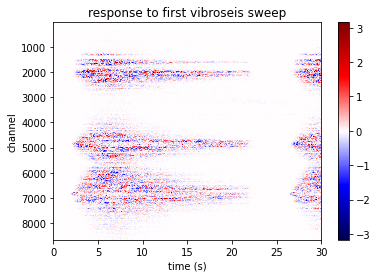

In [44]:
title='response to first vibroseis sweep'
beginningCh = startTrNumber+chNumberFor0thTrace
endingCh =  endTrNumber+chNumberFor0thTrace
plotSpaceTime(data, 0, secondsPerRecord, beginningCh, endingCh, title, samplesPerSecond) # call the actual plotting function

Plot a time snapshot on the geometry at 3.5 seconds (note: could extend this to make a movie)

In [37]:
def plotTimeSnapshot(xLocs, yLocs, dataChT, timeInSeconds, sampleRate, subsample=1, clip=0):
  # INPUTS:
  # xLocs: ***
  # yLocs: ***
  # dataChT: ***
  # timeInSeconds: ***
  # sampleRate: ***
  # subsample: ***** if = 1 (default) no spatial subsampling is done
  # clip: ****
  # OUTPUTS: N/A
  # PURPOSE:
  # Generates a scatter plot of sensor locations and color-codes the markers by 
  # the strain rate measured at a particular point in time.

  # time sample of interest
  timeID = int(timeInSeconds*sampleRate)

  # default color clipping behavior is to just set the max color value to the max absolute value in this snapshot
  if(clip == 0):
    clip = np.max(np.absolute(dataChT[:,timeID])) 

  plt.figure()
  plt.scatter(xLocs[::subsample],yLocs[::subsample],c=dataChT[::subsample,timeID],linewidth=0,s=2,cmap='seismic',vmin=-clip,vmax=clip)
  plt.colorbar()
  plt.xlabel('x UTM (m)')
  plt.ylabel('y UTM (m)')
  plt.title('signal at '+str(timeInSeconds)+' seconds',fontsize=14)

Plot a snapshot of the wavefield at a particular time, 3.5 seconds for example.

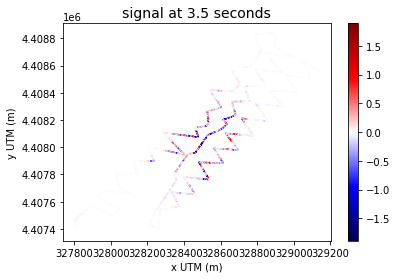

In [38]:
time = 3.5 # time of intereset (in seconds)
plotTimeSnapshot(x, y, data, time, samplesPerSecond)

We can use a widget to easily change the time of the snapshot. 

Note: it does take a little time to regenerate each one, so if you're impatient you may want to set subsample to an integer > 1 (so for instance is subsample = 10, then only every 10th channel will be plotted).

In [39]:
# set a single  color clip for all time snapshots (so they're all on the same colorscale)
overallClip  = np.percentile(np.absolute(data),99) # take the 99th %tile of absolute values of whole data window as max

def interactiveSnapshot(timeInSec):
  # This is a wrapper around plotTimeSnapshot so that the widget just depends on the 
  # time of interest in seconds. This has no subsampling (so 2nd to last arg is 1).
  plotTimeSnapshot(x, y, data, timeInSec, samplesPerSecond, 1, overallClip)

# has a widget that lets you check the time snapshot at 1, 1.5, 2, 2.5, ..., 24.5, 25 seconds
interactive_plot = widgets.interactive(interactiveSnapshot, timeInSec=(1,25,0.5)) 
interactive_plot

interactive(children=(FloatSlider(value=13.0, description='timeInSec', max=25.0, min=1.0, step=0.5), Output())…

## Effect of sensor orientation on  response

Let's zoom in on just channels 1500-2500 during 7-8 seconds while . These channels make a few tight turns, so they'll let us see how response varies with geometry. First check  out this subset of the geometry.

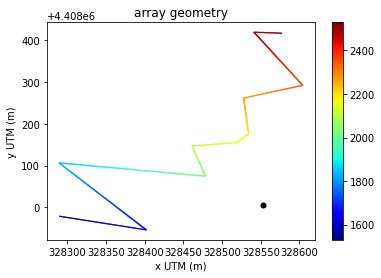

In [47]:
startCh = 1500
endCh = 2500
startSec = 7
endSec = 8

plt.scatter(x[startCh:endCh],y[startCh:endCh],c=ch[startCh:endCh],linewidth=0,s=2,cmap=plt.get_cmap('jet'))
plt.colorbar()
plt.xlabel('x UTM (m)') # ******fix x-ticks
plt.ylabel('y UTM (m)')
plt.title('array geometry')
plt.scatter(srcX,srcY,c='k',linewidth=0) # plot the source location
plt.show()

Now actually plot the data. Investigate where the corners of the array line up with the data. What do you notice?



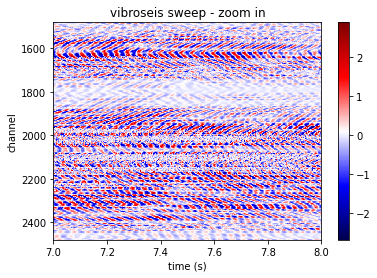

In [48]:
title='vibroseis sweep - zoom in'
beginningCh = startCh+chNumberFor0thTrace
endingCh =  endCh+chNumberFor0thTrace
plotSpaceTime(data, startSec, endSec, beginningCh, endingCh, title, samplesPerSecond) # call the actual plotting function

**Questions for small group investigation:**

* Look at the last segment. How would waves from that source location be hitting it? What do you notics about the amplitudes?
* Why is the amplitude from ~1750 to ~1900 so much lower than 1500 to ~1650 even though it is closer to the source? 
* Change your visualization codes in the cell above and below so you can zoom in on much smaller subsets of channels. Can you figure out where corners are based on the waveforms?
* Try zooming in on different subsets of the array. What do you see about their response? 

In [49]:
## Spectral Analysis

****text to introduce looking at spectrum during vibroseis sweep and have reference to fourier transform info*

In [59]:
def plotSpecOneCh(chOfInterest,dataArray,sampleRate,title): 
  spectrum = ft.fft(dataArray[chOfInterest,:]) # will need to fold back****
  frqBins = int(spectrum.size/2)
  # frequencies of interest
  NyquistFrq = sampleRate/2.0 # the Nyquist frequency
  frqs = np.linspace(0,NyquistFrq,num=frqBins)

  plt.figure()
  plt.plot(frqs,np.absolute(spectrum[:frqBins]))
  plt.xlabel('Frequency (Hz)')
  plt.ylabel('Amplitude')
  plt.title(title)


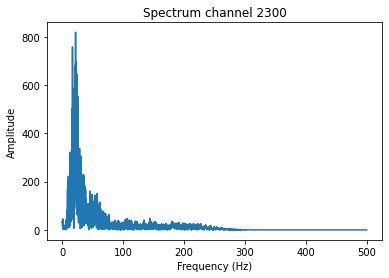

In [60]:
ch = 2300
plotSpecOneCh(ch+chNumberFor0thTrace,data,samplesPerSecond,'Spectrum channel '+str(ch))

In [61]:
dataFT = ft.fft(data,axis=-1) # by default, do this along the last axis, but can specify others
specAmplitudes = np.absolute(dataFT) # just get the magnitude of energy in each 

def plotArraySpec(dataArray,sampleRate,title):
  spectrum = ft.fft(dataArray,axis=-1) 
  frqBins = int(spectrum.shape[1]/2)
  # frequencies of interest
  NyquistFrq = sampleRate/2.0 # the Nyquist frequency
  frqs = np.linspace(0,NyquistFrq,num=frqBins)

  plt.figure()
  plt.imshow(np.absolute(spectrum[:,:frqBins])) # fix so right labels
  plt.xlabel('Frequency (Hz)')
  plt.ylabel('Channel')
  plt.title(title)
  